# Adaptive sampling
This tutorial demonstrates how to use adaptive sampling when fitting a [radial basis function](https://idaes-pse.readthedocs.io/en/stable/explanations/modeling_extensions/surrogate/api/pysmo/index.html) (RBF) surrogate model. 

## Motivation
RBFs can represent highly nonlinear relationships that are present in the underlying physical phenomena of corrosion. There is a trade-off in selecting the training points for RBF surrogates: more training points improve accuracy, but additional points also increase model complexity since each additional training point adds a term to the RBF. To minimize the number of training points for the target accuracy, we use an adaptive sampling approach to select points that improve the surrogate model accuracy.

## Outline of tutorial
1. Corrosion surrogate models
2. Adaptive sampling approach
3. Fit surrogate using adaptive sampling
4. Compare to fitting without adaptive sampling

# 1. Corrosion surrogate models
We aim to fit surrogate models for general and localized corrosion as functions of temperature $T$, salinity $w$, pH, and dissolved oxygen $DO$: 
$$CR = f(T, w, pH, DO)$$
$$V_{rp}-V_{c} = f(T, w, pH, DO)$$

For the purpose of this tutorial, we will fit the localized corrosion surrogate as a function of temperature and dissolved oxygen: 
$$V_{rp}-V_{c} = f(T,DO)$$

We will use data that has been generated as a function of temperature and dissolved oxygen for the repassivation-corrosion potential difference to predict localized corrosion. 

<img src="figures\synthetic_material_behavior.png" alt="synthetic_material_behavior" width="624" align="center"/>

# 2. Adaptive sampling approach
We use an adaptive sampling approach and PySMO to fit radial basis functions with a cubic basis for the corrosion rate and repassivation corrosion potential difference for each material. 

We first select an initial training size and use [Hammersley sampling](https://idaes-pse.readthedocs.io/en/1.5.1/surrogate/pysmo/pysmo_hammersley.html) to select initial training set. We then add additional samples to improve the model fit (see figure below). For fitting the general corrosion surrogate, we add the samples with the worst absolute error. For the localized corrosion surrogate, we add samples in two phases. In the first phase, we consider the set of misclassified samples and add the samples with the worst absolute error to improve the classification accuracy near 0 V for localized corrosion. In the second phase, we add the samples with the worst absolute error to minimize the overall error. 

<img src="figures\adaptive sampling routine.png" alt="adaptive sampling routine" width="624" align="center"/>

# 3. Fit surrogate using adaptive sampling
## 3.1 Load data

In [37]:
from pathlib import Path
import pandas as pd
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))
import fit_surrogates

# load the localized corrosion data
current_directory = Path.cwd()
survey_path = (
    current_directory.parent
    / f"synthetic_corrosion_data/synthetic_potential_difference.csv"
)
data = pd.read_csv(survey_path)
print(data.head())
print(f'Number of data points: {len(data)}')

   temperature_C  do_mg_L  synthetic_potential_difference_V
0             25      0.0                          0.595005
1             25      0.5                          0.352455
2             25      1.0                          0.104955
3             25      1.5                          0.101786
4             25      2.0                          0.098571
Number of data points: 255


## 3.2 Assign inputs and output
Our inputs are temperature and dissolved oxygen. The output is the potential difference. We printed the column names above. 

In [38]:
inputs = ["temperature_C", "do_mg_L"]
output = "synthetic_potential_difference_V"
# get the input bounds
input_bounds = {
    name: (min(data[name]), max(data[name]))
    for i, name in enumerate(inputs)
}

## 3.3 Select adaptive sampling parameters and fit surrogate
We will use helper functions from `fit_surrogates` fit the surrogates with adaptive sampling.

First select the adaptive sampling parameters: the initial number of samples, number of iterations for adding the misclassified samples with the highest error, number of iterations of adding the samples with the highest error, and the number of damples to add per iteration. 

Note that increasing the number of iterations increases the number of times the surrogate is refit, which can make this take several minutes to run if many iterations chosen.

In [70]:
%%capture
# Adaptive sampling parameters
n = (10, # initial number of samples
     4, # number of iterations of adding worst misclassified samples
     4, # number of iterations of adding worst error samples
     4) # number of samples to add per iteration

# create surrogate object
basis = 'cubic'
sf = fit_surrogates.surrogateFitting(data=data,
                          input_labels=['temperature_C','do_mg_L'],
                          output_labels=[output],
                          n_init=n[0],
                          n_mid=n[1],
                          n_final=n[2],
                          n_add=n[3],
                          initial_sample_type='Hammersley',
                          basis=basis)

# Initial fit
sf.fit_surrogate(output)

# Add points based on worst misclassified
for i in range(sf.n_mid):
    sf.add_training_sample(type='worst_misclassified', output=output)
    sf.fit_surrogate(output)

# Add points based on worst error
for i in range(sf.n_final):
    sf.add_training_sample(type='worst_error', output=output)
    sf.fit_surrogate(output)

2026-01-22 16:50:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:08 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully
2026-01-22 16:50:08 [INFO] idaes.core.surrogate.

## 3.4 Assess the error metrics.
For this surrogate, we want the maximum absolute error to be low, indicating that the surrogate aligns with the generated data. While minimizing the overall error is important, we also care about ensuring that we have a high accuracy in predicting whether localized corrosion occurs. Therefore, we also define a classification accuracy and [balanced accuracy](https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_data).

In [71]:
# print the error metrics
errors = ['MSE', 'R2', 'maxAE', 'misclassification', 'balanced_accuracy']
for err in errors:
    print(f'{err}: {str(round(sf.surrogates[output][err][-1], 4))}') # final error

MSE: 0.0001
R2: 0.992
maxAE: 0.0477
misclassification: 0.3922
balanced_accuracy: 99.4845


## 3.5 Plot error metrics vs. iteration
We can see how adaptive sampling improves the error metrics by plotting the error metrics vs. iterations. The gray shaded region is when we add the worst misclassified samples to the training set and the white region is when we add the samples with the highest error. 

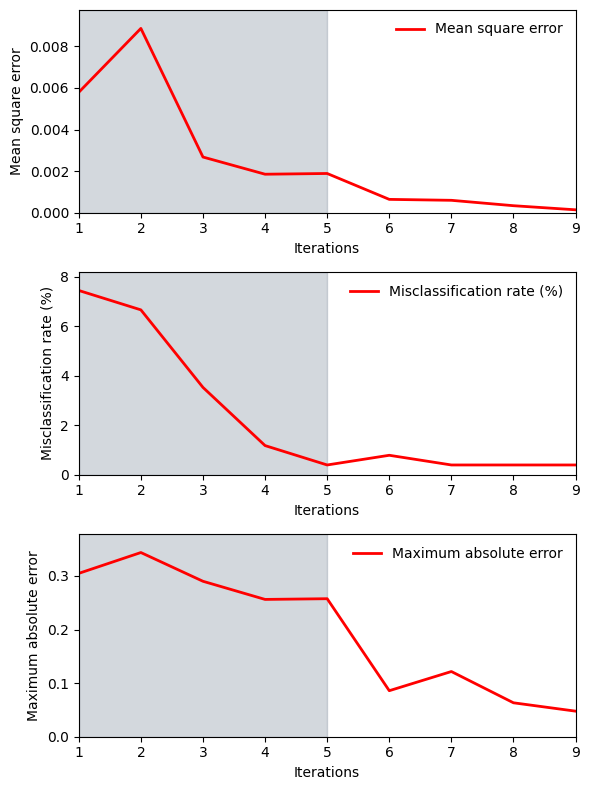

In [72]:
filename = folder /f'errors_vs_iteration.png'
sf.plot_errors(output, filename=filename)

# 4. Compare to fitting without adaptive sampling
Fit a surrogate with the equivalent number of training samples. 
We want the maximum absolute error (maxAE) to be less than 0.05 V (SHE), the misclassification rate less than 1%, and the balanced accuracy greater than 99%. 

In [73]:
%%capture
# Number of training samples = n_initial + n_add(n_iter_worst_misclassified + n_iter_worst)
n_initial = n[0] + n[3]*(n[1] + n[2])
sf_initial = fit_surrogates.surrogateFitting(data=data,
                          input_labels=['temperature_C','do_mg_L'],
                          output_labels=[output],
                          n_init=n_initial,
                          initial_sample_type='Hammersley',
                          basis=basis)

# Fit surrogate
sf_initial.fit_surrogate(output)

2026-01-22 16:50:18 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output synthetic_potential_difference_V trained successfully


## 4.1 Compare the errors

In [74]:
print('Error: Adaptive sampling fit error, One-shot fit error')
for err in errors:
    print(f'{err}: {str(round(sf.surrogates[output][err][-1], 4))},  {str(round(sf_initial.surrogates[output][err][-1], 4))}') # final error

Error: Adaptive sampling fit error, One-shot fit error
MSE: 0.0001,  0.0006
R2: 0.992,  0.9674
maxAE: 0.0477,  0.1336
misclassification: 0.3922,  1.1765
balanced_accuracy: 99.4845,  99.0506
